In [1]:
import os
import h5py
import struct
import numpy as np
import configparser
import matplotlib.pyplot as plt

In [2]:
config = configparser.ConfigParser()
config.read('file_paths.ini')
config.sections()

['MAIN_DATA_PATH', 'FY3', 'HIMAWARI']

In [3]:
# File paths for FengYun-3E data.
FY3E_DATA_FOLDERS_LOCATION = config['FY3']['FY3E_MAIN_DATA_LOCATION']
FY3E_RAW_DATA_LOCATION = config['FY3']['FY3E_RAW_DATA_LOCATION']
FY3E_L0_DATA_LOCATION = config['FY3']['FY3E_L0_DATA_LOCATION']
FY3E_L1_DATA_LOCATION = config['FY3']['FY3E_L1_DATA_LOCATION']
FY3E_L1_GOE_DATA_LOCATION = config['FY3']['FY3E_L1_GOE_DATA_LOCATION']
FY3E_L1_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_IMAGE_DATA_LOCATION']
FY3E_L1_GEOREF_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_GEOREF_IMAGE_DATA_LOCATION']

In [4]:
fy3e_L0_files_paths = [FY3E_L0_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L0_DATA_LOCATION)]
fy3e_l1_geo_files_paths = [FY3E_L1_GOE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_GOE_DATA_LOCATION)]
fy3e_l1_image_files_paths = [FY3E_L1_IMAGE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_IMAGE_DATA_LOCATION)]

print('L0 files -', fy3e_L0_files_paths)
print()
print('GEO files -', fy3e_l1_geo_files_paths)
print()
print('Image files -', fy3e_l1_image_files_paths)

L0 files - ['E:/Satellite data/FY-3E/L0/Y3E_08534_230226070855_7860R_MERSI.DAT']

GEO files - ['E:/Satellite data/FY-3E/L1/geo/FY3E_MERSI_GRAN_L1_20230228_2215_GEOQK_V0.HDF']

Image files - ['E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230228_2215_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20240301_0915_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0435_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0935_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0520_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0840_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0845_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1020_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1745_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2100_0250

In [34]:
data = h5py.File(fy3e_l1_image_files_paths[0])

In [40]:
np.array(data['Calibration']['SV_DN_Average_Emissive']).shape

(2, 200)

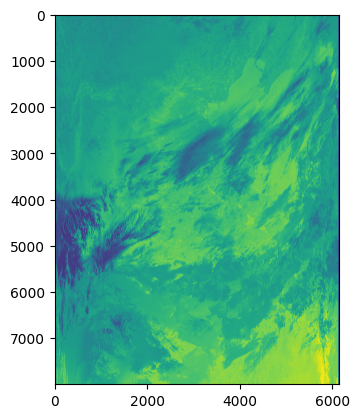

In [6]:
plt.imshow(np.array(data['Data']['EV_250_Emissive_b6']))

In [6]:
def read_uint12(data_chunk):
    data = np.frombuffer(data_chunk, dtype=np.uint8)
    fst_uint8, mid_uint8, lst_uint8 = np.reshape(data, (data.shape[0] // 3, 3)).astype(np.uint16).T
    fst_uint12 = (fst_uint8 << 4) + (mid_uint8 >> 4)
    snd_uint12 = ((mid_uint8 % 16) << 8) + lst_uint8
    return np.reshape(np.concatenate((fst_uint12[:, None], snd_uint12[:, None]), axis=1), 2 * fst_uint12.shape[0])

In [7]:
l0_data = open(fy3e_L0_files_paths[0], 'br')

In [8]:
header_size = 1331906 - 119938 - 52424
header_size

1159544

In [9]:
data = l0_data.read(header_size)

In [10]:
section_1, section_2 = [], []
section_3, section_4, section_5, section_6, section_7 = [], [], [], [], []

data1_agg, data2_agg, data3_agg, data4_agg = [], [], [], []

hyperX_data_agg = []

for _ in range(500):
    data1 = l0_data.read(554)
    data1_agg.append(data1)

    data2 = l0_data.read(25930)
    data2_agg.append(data2)

    data3 = l0_data.read(17290)
    data3_agg.append(data3)

    data4 = l0_data.read(8650)
    data4_agg.append(data4)

    # hyperX_data = l0_data.read(52424)
    # hyperX_data_agg.append(hyperX_data)
    
    for i in range(40):
        data = l0_data.read(9226)
        section_1.append(read_uint12(data[10:]))

    for i in range(40):
        data = l0_data.read(9226)
        section_2.append(read_uint12(data[10:]))
        
    for i in range(40):
        data = l0_data.read(9226)
        
        section_3.append(read_uint12(data[10:2314]))
        section_4.append(read_uint12(data[2314:4618]))
        section_5.append(read_uint12(data[4618:6922]))
        section_6.append(read_uint12(data[6922:9226]))


section_1 = np.array(section_1)
section_2 = np.array(section_2)
section_3 = np.array(section_3)
section_4 = np.array(section_4)
section_5 = np.array(section_5)
section_6 = np.array(section_6)

In [21]:
np.array(data2_agg)[2]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d\x06 p\x06\xc0h\x06`k\x06\xa0m\x07\x00i\x06\xa0f\x06\xe0d\x07\x10k\x06\xe0p\x06\x90n\x06\x80u\x07\x10l\x06\xb0n\x07 n\x06\xd0m\x07`q\x06\xe0r\x06\xb0i\x07 j\x07\x00n\x07\x10i\x06\xc0l\x07\x00l\x07\x10p\x06\xe0j\x06\xb0q\x06\xb0u\x06\xb0j\x06pn\x06\xa0k\x06\x80k\x06\xe0p\x06pj\x070r\x06\xb0j\x06\xf0u\x06\xb0r\x06\x90b\x06\xe0g\x06@l\x06\xd0n\x06`n\x06`l\x07\x00g\x06\xb0h\x06\x80n\x06`f\x06\xd0s\x06\xa0h\x06\xa0l\x07Pj\x06\x90l\x06\xe0h\x06\xb0l\x06\xe0e\x06Ph\x06\xc0p\x06\xc0i\x06\x90j\x07@n\x06\x80b\x06\xc0n\x07\x10f\x06`l\x06\x80l\x06Pc\x06\xa0j\x06pn\x06\x90o\x06\xd0l\x07po\x06\xe0i\t\x80\x94\t\xc0\x99\t\xa0\x9e\t\xe0\x97\t\x80\x97\n0\x95\t\xa0\x99\t\x90\x95\t\xd0\x9c\tp\x91\t\xb0\x9a\t`\xa2\t\xd0\x9f\tp\x99\t\xb0\x9e\tp\x9b\t\x90\x93\x08\xb0\x9e\t\x90\x93\t\x80\x95\t\x80\x9b\t`\x99\t\xc0\xa1\t\xb0\x9c\t\x90\x98\n\x00\x9c\t\xf0\x96\t\xb0\x95\t\xb0\x93\t0\x9f\t\x80\x9f\t\xd0\x9b\t\x90\x97\t\x80\x99\t\xb0\x98\tP\x98\t`\x97\t\xf0\x9d\t\xb0\x9d\t\xa

In [30]:
onr_line = np.array(data2_agg)[2][:226]

In [33]:
onr_line[:10]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d'

In [32]:
read_uint12(onr_line[10:])

array([ 98, 112, 108, 104, 102, 107, 106, 109, 112, 105, 106, 102, 110,
       100, 113, 107, 110, 112, 105, 110, 104, 117, 113, 108, 107, 110,
       114, 110, 109, 109, 118, 113, 110, 114, 107, 105, 114, 106, 112,
       110, 113, 105, 108, 108, 112, 108, 113, 112, 110, 106, 107, 113,
       107, 117, 107, 106, 103, 110, 106, 107, 104, 107, 110, 112, 103,
       106, 115, 114, 107, 106, 111, 117, 107, 114, 105,  98, 110, 103,
       100, 108, 109, 110, 102, 110, 102, 108, 112, 103, 107, 104, 104,
       110, 102, 102, 109, 115, 106, 104, 106, 108, 117, 106, 105, 108,
       110, 104, 107, 108, 110, 101, 101, 104, 108, 112, 108, 105, 105,
       106, 116, 110, 104,  98, 108, 110, 113, 102, 102, 108, 104, 108,
       101,  99, 106, 106, 103, 110, 105, 111, 109, 108, 119, 111, 110,
       105], dtype=uint16)

In [135]:
782 - 563

219

In [154]:
pic_size = 219
pic_count = 80
offset_start = 559

In [155]:
images = []

for k, i in enumerate(range(offset_start, offset_start + pic_size * pic_count,  pic_size)):
    matrix = np.array(list(map(list, hyperX_data_agg)))[:, i:i + pic_size]

    res = []
    for j in range(500):
        res.append(read_uint12(bytes(matrix.tolist()[j])))

    res = np.array(res)

    plt.imsave('big boi/' + f'img_{k}.png', res)

KeyboardInterrupt: 

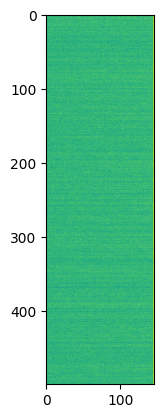

In [134]:
plt.imshow(res)

In [104]:
plt.imsave('temp2.png', res)

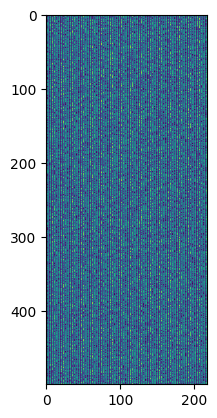

In [69]:
plt.imshow(np.array(list(map(list, hyperX_data_agg)))[:, 563:781])

In [260]:
plt.imsave('hyperX_data_agg.png', list(map(list, hyperX_data_agg)))

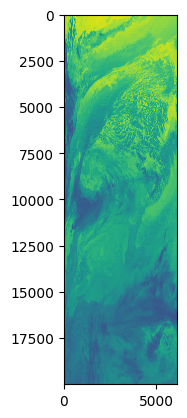

In [53]:
plt.imshow(section_1)

In [ ]:
plt.imsave('b6.png', section_1)
plt.imsave('b7.png', section_2)

In [214]:
plt.imsave('b1.png', section_3)
plt.imsave('b2.png', section_4)
plt.imsave('b3.png', section_5)
plt.imsave('b4.png', section_6)